<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Diego Alvarez Jeria</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


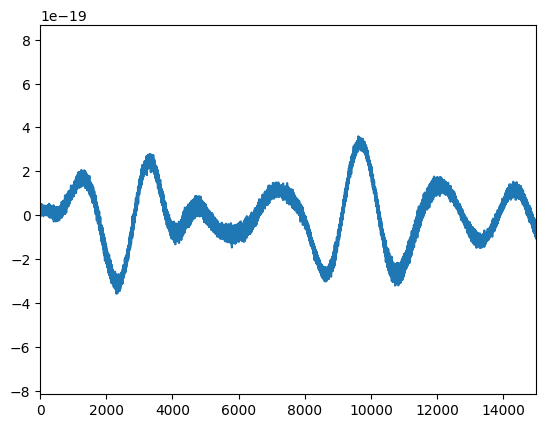

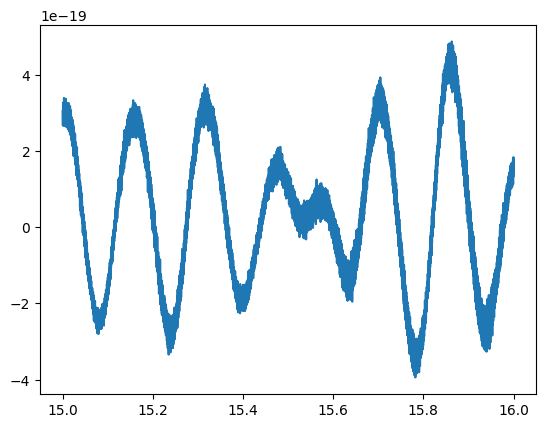

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
import shutil
from scipy.signal import resample, welch, chirp, spectrogram, butter, sosfilt
from scipy.signal.windows import tukey
import librosa
from pathlib import Path



nombre_archivo = "H-H1_GWOSC_16KHZ_R1-1126259447-32.txt"
archivo_comprimido = f"{nombre_archivo}.gz"
archivo_descomprimido =  nombre_archivo

# Descomprimir archivo 

with gzip.open(archivo_comprimido, "rb") as archivo_in:
  with open(archivo_descomprimido, "wb") as archivo_out:
    shutil.copyfileobj(archivo_in, archivo_out)

# Cargar datos
strain = np.loadtxt(archivo_descomprimido, delimiter=",", skiprows=1, dtype=float)

# Visualizar señal completa
plt.plot(strain)
plt.xlim(0, 15000)
plt.show()

# Recorte de señal
fs = 16000
lowtime = 15
hightime = 16
low_sample = int(lowtime * fs)
high_sample = int(hightime * fs)

time_steps = np.linspace(lowtime, hightime, high_sample - low_sample)
plt.plot(time_steps, strain[low_sample:high_sample])
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

Reproduciendo señal de la etapa 1


Reproduciendo señal de la etapa 2


Reproduciendo señal de la etapa 3


Reproduciendo señal de la etapa 4


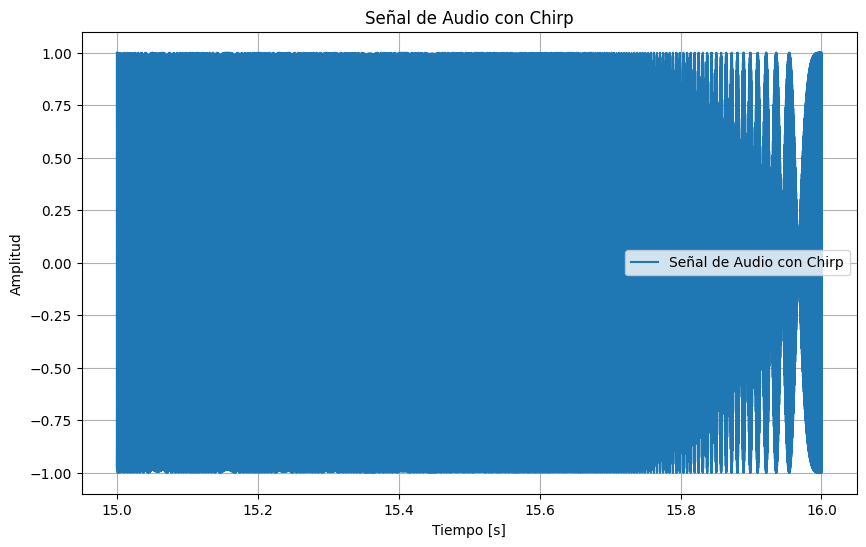

In [3]:

from IPython.display import Audio
Audio(strain,rate=16000)

#Se divide en 4 etapas la señal para poder realizar el analisis
rate=16000
div_strain = len(strain) // 4
etapas = [strain[i:i+div_strain] for i in range(0, len(strain), div_strain)]

for i, signal in enumerate(etapas):
    print(f"Reproduciendo señal de la etapa {i+1}")
    display(Audio(signal, rate=rate))


#mostramos las sseñal como audio y la graficamos 
f0 = 0
f1 = 16000
duration = 32

chirp_signal = chirp(time_steps, f0=f0, f1=f1, t1=duration, method='linear') #obtenemos la señal con chirp

audio_with_chirp = strain[low_sample:high_sample] + chirp_signal[:len(strain)]  #transformamos la señal en audio

# Graficar la señal de audio original y la señal con chirp
plt.figure(figsize=(10, 6))
plt.plot(time_steps, audio_with_chirp, label='Señal de Audio con Chirp')
plt.title('Señal de Audio con Chirp')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


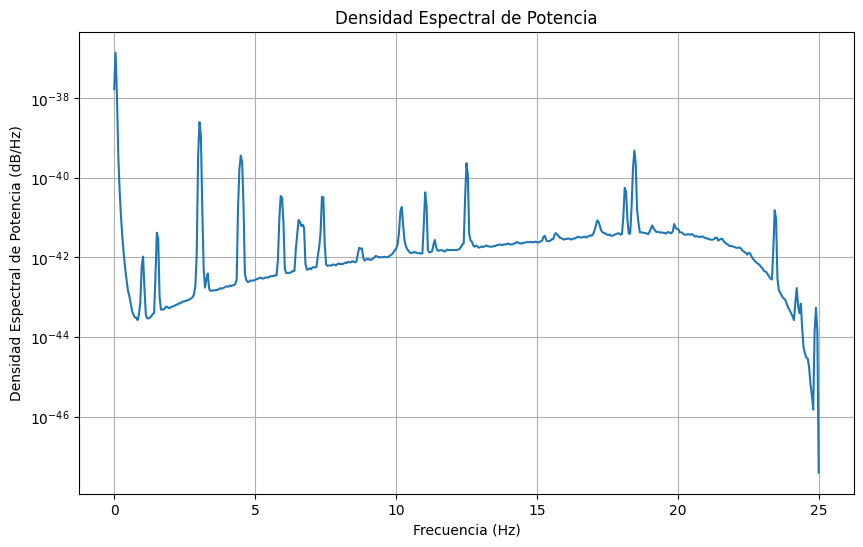

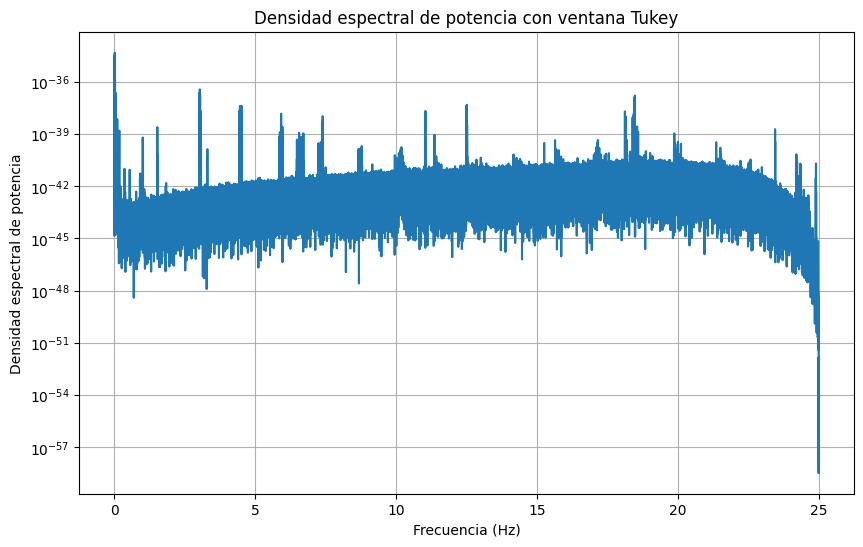

In [4]:



# Cálculo de la PSD sin ventana Tukey
frequencies, psd = welch(strain, fs=50, nperseg=1024)

# Graficar la PSD en escala logarítmica
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.title('Densidad Espectral de Potencia')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral de Potencia (dB/Hz)')
plt.grid(True)
plt.show()

# Parámetro alpha para la ventana Tukey
alpha = 0.5

# Cálculo de la PSD con ventana Tukey
frequencies, psd = welch(strain, fs=50, window=tukey(len(strain), alpha), nperseg=524288, noverlap=128)

# Graficar la PSD con ventana Tukey
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral de potencia')
plt.title('Densidad espectral de potencia con ventana Tukey')
plt.grid(True)
plt.show()

plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


C:\Users\diego\AppData\Local\Temp\ipykernel_19680\3786624518.py:25: RuntimeWarning: divide by zero encountered in divide
  whitening_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))


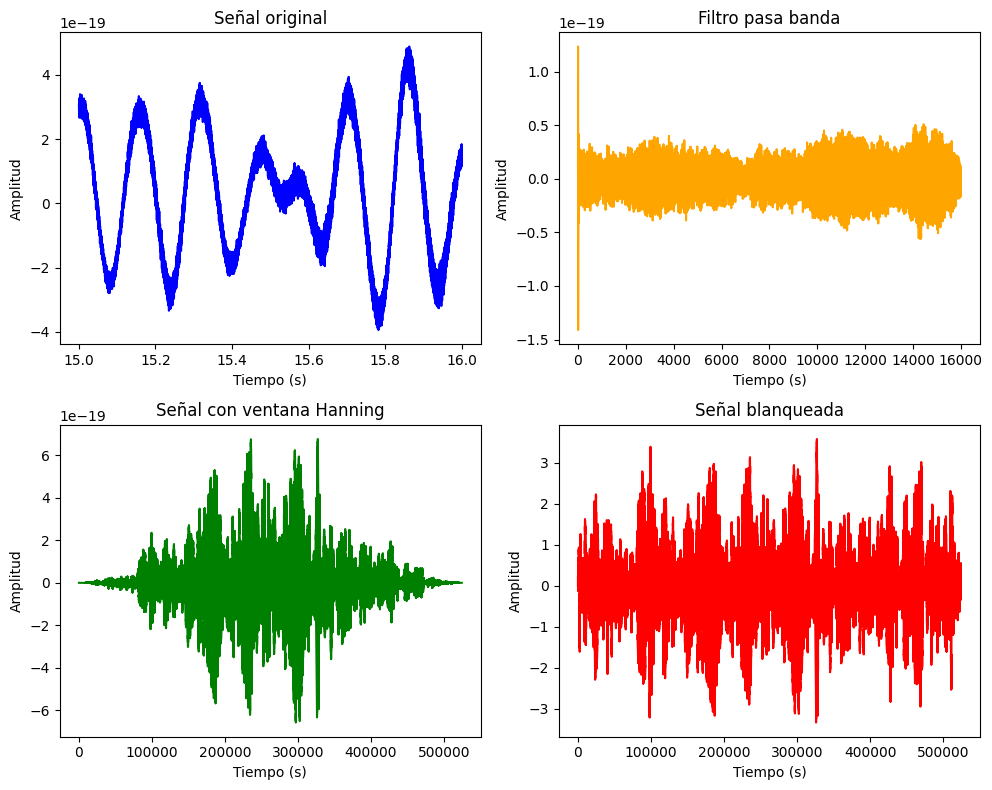

In [19]:

# Definir parámetros de la señal
fs = 16000
time = np.arange(strain.size)
lowtime, hightime = 15, 16
low_sample, high_sample = int(lowtime * fs), int(hightime * fs)
time_steps = np.linspace(lowtime, hightime, strain[low_sample:high_sample].size)

# Aplicar ventana de Hanning
window = np.hanning(len(strain))
windowed_signal = strain * window

# Filtro pasa banda
lowcut, highcut = 500, 3000
order = 4
nyquist_freq = 0.5 * fs
low, high = lowcut / nyquist_freq, highcut / nyquist_freq
sos = butter(order, [low, high], btype='band', output='sos')
filtered_signal = sosfilt(sos, strain[low_sample:high_sample])

# Descomposición SVD
covariance_matrix = np.cov(strain, time)
U, S, Vt = np.linalg.svd(covariance_matrix)

# Matriz de blanqueo
whitening_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))

y=len(strain)
# Aplicar matriz de blanqueo
strain_mean = np.mean(strain)
strain_std = np.std(strain)
whitened_signal = (strain - strain_mean) / strain_std

# Graficar las señales
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(time_steps, strain[low_sample:high_sample], color='blue')
axs[0, 1].plot(filtered_signal, color='orange')
axs[1, 0].plot(windowed_signal, color='green')
axs[1, 1].plot(whitened_signal, color='red')

for ax in axs.flat:
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Amplitud')

axs[0, 0].set_title('Señal original')
axs[0, 1].set_title('Filtro pasa banda')
axs[1, 0].set_title('Señal con ventana Hanning')
axs[1, 1].set_title('Señal blanqueada')

plt.tight_layout()
plt.show()


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

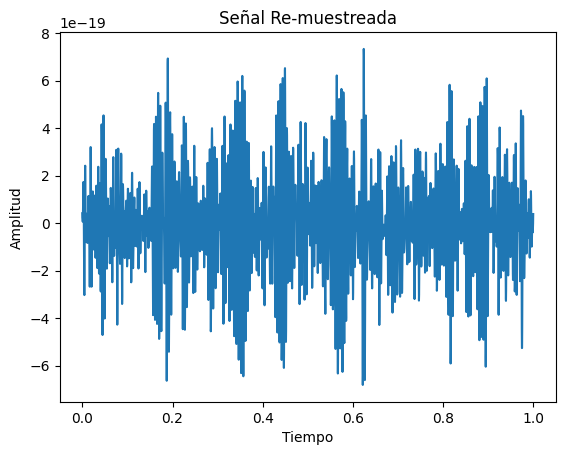

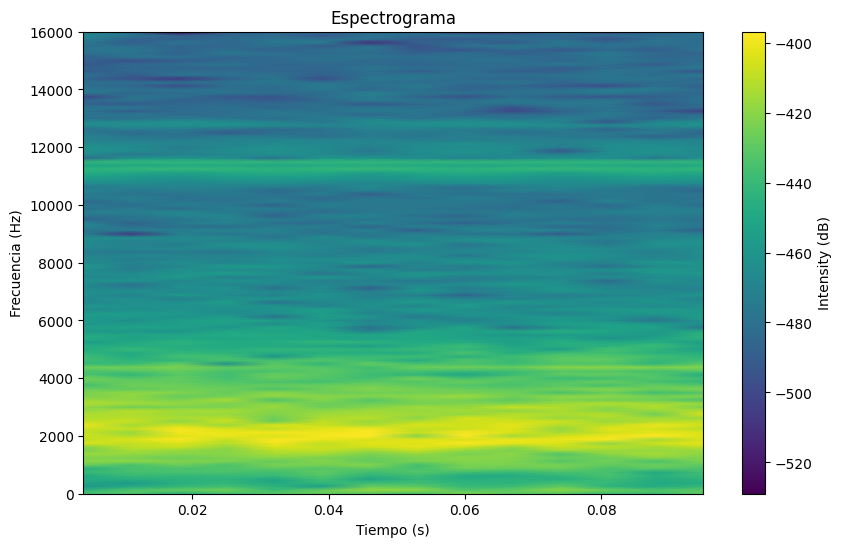

In [20]:
# Resampleo de la señal
fs = 32000
new_fs = 200
x_resampled = resample(strain, int(len(strain) * (new_fs / fs)))

t_resampled = np.linspace(0, 1, len(x_resampled), endpoint=False)
plt.plot(t_resampled, x_resampled)
plt.title('Señal Re-muestreada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.show()

# Graficar espectrograma
frequencies, times, Sxx = spectrogram(x_resampled, fs)

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Espectrograma')
plt.show()


